In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-11-11 17:38:42.838600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 17:38:42.848199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 17:38:42.851129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1731346723.819434  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346723.845501  158967 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"
train_filename = "../snakeMSA/data/homfam/train/blm"
#train_filename = "test/data/bamD.fa"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"
ref_filename = "../snakeMSA/data/homfam/refs/blm"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        inv_gamma_alpha=3.,
                                        inv_gamma_beta=3.)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens))) #comment out to disable cropping
        config["max_surgery_runs"] = 2
        config["batch_size"] = 95
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

3.0 3.0
Training of 4 models on file blm
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-11 17:39:14.327477: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [257 255 262 262] on 9105 sequences.
Batch size= 95 Learning rate= 0.05
Using sequence weights  [0.25       0.25       0.25       ... 0.07692308 0.0020284  0.125     ] .
Using 1 GPUs.
3.0 3.0
3.0 3.0
3.0 3.0


I0000 00:00:1731346992.224590  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346992.224797  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346992.224917  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346992.225066  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1731346994.132506  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346994.132711  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346994.132830  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731346994.132981  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

100/100 - 43s - 428ms/step - loss: 908.9509 - loglik: -8.9554e+02 - prior: -1.3415e+01 - aux_loss: 0.0000e+00
Epoch 2/10
100/100 - 31s - 310ms/step - loss: 839.4712 - loglik: -8.2859e+02 - prior: -1.0886e+01 - aux_loss: 0.0000e+00
Epoch 3/10
100/100 - 31s - 310ms/step - loss: 836.5313 - loglik: -8.2584e+02 - prior: -1.0695e+01 - aux_loss: 0.0000e+00
Epoch 4/10
100/100 - 31s - 307ms/step - loss: 833.0779 - loglik: -8.2247e+02 - prior: -1.0604e+01 - aux_loss: 0.0000e+00
Epoch 5/10
100/100 - 31s - 310ms/step - loss: 831.9737 - loglik: -8.2136e+02 - prior: -1.0615e+01 - aux_loss: 0.0000e+00
Epoch 6/10
100/100 - 31s - 311ms/step - loss: 828.4836 - loglik: -8.1793e+02 - prior: -1.0558e+01 - aux_loss: 0.0000e+00
Epoch 7/10
100/100 - 31s - 313ms/step - loss: 829.3943 - loglik: -8.1890e+02 - prior: -1.0498e+01 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.
3.0 3.0


I0000 00:00:1731347224.923104  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347224.923300  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347224.923417  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347224.923565  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(0, 5), (7, 1), (8, 1), (24, 1), (28, 1), (30, 2), (31, 2), (32, 2), (64, 1), (65, 1), (70, 4), (71, 2), (91, 1), (94, 4), (95, 1), (100, 1), (101, 1), (103, 1), (113, 1), (136, 1), (137, 1), (138, 1), (156, 2), (157, 1), (158, 1), (160, 1), (163, 3), (164, 1), (165, 2), (166, 2), (188, 1), (194, 3), (199, 1), (200, 1), (202, 1), (203, 1), (204, 5), (205, 1), (206, 1), (207, 1), (215, 2), (216, 1), (217, 3), (218, 2), (237, 1), (247, 1), (250, 1), (251, 2), (257, 4)]
discards model 0: []
expansions model 1: [(0, 5), (7, 1), (8, 1), (17, 1), (23, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (35, 1), (63, 1), (68, 6), (69, 2), (92, 4), (93, 2), (98, 1), (99, 2), (101, 1), (112, 1), (133, 1), (134, 1), (135, 1), (136, 1), (151, 1), (152, 2), (153, 1), (154, 1), (155, 1), (156, 1), (159, 5), (160, 2), (161, 1), (189, 3), (197, 1), (198, 1), (200, 5), (201, 2), (203, 1), (212, 1), (213, 1), (214, 2), (215, 2), (217, 2), (234, 1), (247, 1), (248, 1), (255, 4)]
discar

I0000 00:00:1731347238.266007  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347238.266251  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347238.266374  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347238.266523  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1731347239.994440  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347239.994701  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347239.994819  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347239.994965  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

100/100 - 45s - 447ms/step - loss: 829.5503 - loglik: -8.1102e+02 - prior: -1.8529e+01 - aux_loss: 0.0000e+00
Epoch 2/20
100/100 - 34s - 338ms/step - loss: 810.6885 - loglik: -8.0029e+02 - prior: -1.0402e+01 - aux_loss: 0.0000e+00
Epoch 3/20
100/100 - 34s - 337ms/step - loss: 808.4911 - loglik: -7.9898e+02 - prior: -9.5100e+00 - aux_loss: 0.0000e+00
Epoch 4/20
100/100 - 34s - 338ms/step - loss: 805.1567 - loglik: -7.9615e+02 - prior: -9.0086e+00 - aux_loss: 0.0000e+00
Epoch 5/20
100/100 - 34s - 340ms/step - loss: 803.2656 - loglik: -7.9467e+02 - prior: -8.5983e+00 - aux_loss: 0.0000e+00
Epoch 6/20
100/100 - 34s - 341ms/step - loss: 799.7358 - loglik: -7.9141e+02 - prior: -8.3261e+00 - aux_loss: 0.0000e+00
Epoch 7/20
100/100 - 34s - 335ms/step - loss: 798.4871 - loglik: -7.9025e+02 - prior: -8.2352e+00 - aux_loss: 0.0000e+00
Epoch 8/20
100/100 - 34s - 339ms/step - loss: 798.6479 - loglik: -7.9047e+02 - prior: -8.1764e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignme

I0000 00:00:1731347534.723830  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347534.724026  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347534.724145  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347534.724293  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 16 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


Fixed 1404 Viterbi sequences:
C3X8Y5_OXAFO/25-278
D2JC69_STAEP/27-275
Q1XG18_STAAU/27-275
C5QKL8_STAAU/27-275
Q2FC27_STAAU/27-275
...
time for generating output: 69.8900
Wrote file test/data/interactive.alignment.fasta
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
>l=-803.29_t=0.42
.........................................................$I-EEFIVN.RMRE......-TRIPGL..........SVGI..V.....K......E..........N.E.............LIYARGF.......G.....FR...........................Nl...ERG........LP.....ATP.......G....TIYGIGSVTKSF.TAL.SILR........LAEE.....GR........................................L...SLED.....PV.....................DKY......I.......-.....Q.....LK...................---.............LR..........................ISGEPVKIHHLLTHTSG...IPALGY........A....Eafingalgl...............................................DS............................................NWL....P.VSSADDVM....VFMR..G........Y..Edw.V..................................VSR.P......GE............RFFYL.N.........EGYV...LLGHV...........

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1731347620.870015  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347620.870182  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731347620.870293  158967 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

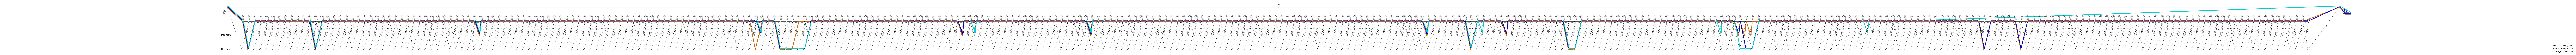

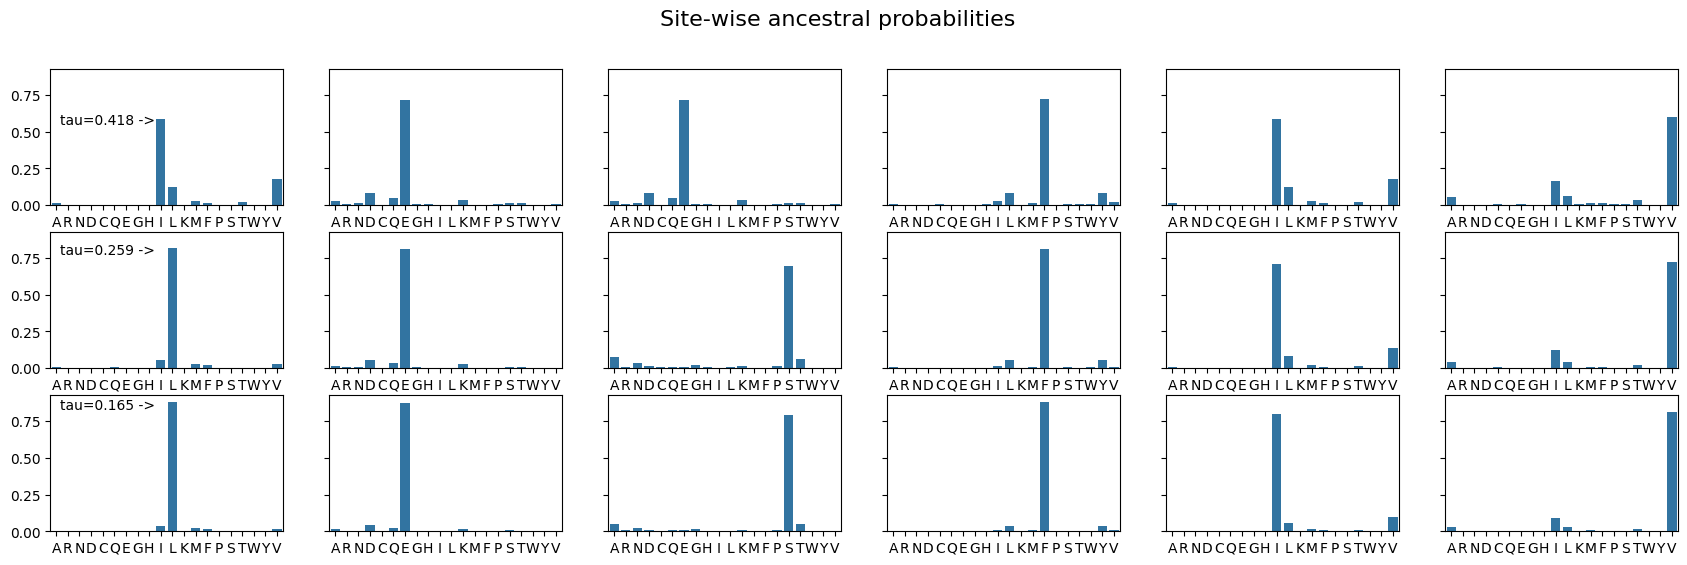

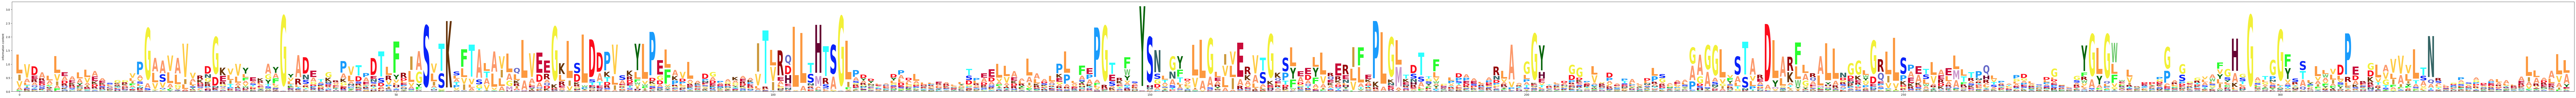

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 4blma
HERE: 3blm
HERE: 1btl
HERE: 1mfo
HERE: 1bul
HERE: 1bsg
HERE: 1bza
HERE: 1shva


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
blm           8          39.1    51.6 [100.0]   [14370]
